# MSC_DA_CA1_Semester_2:
# A Comparative Analysis of CNN, MobileNetV2, and VGG-16 for Potato Leaf Disease Classification: A Big Data Approach Using Hadoop and Apache Spark

**Name:**
Madina Sagatova

**Student ID:**
2021255

**Student email:**
2021255@student.cct.ie

**Programme Title:**
MSc in Data Analytics

***************
Data Source: [Kaggle: Potato Plant Diseases Data](https://www.kaggle.com/datasets/hafiznouman786/potato-plant-diseases-data)

Licence: [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/)
***************

# Imports
***

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from hdfs import InsecureClient
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract, col

# Initialize Spark Session
***

In [2]:
# Create a Spark session 
spark = SparkSession.builder \
       .appName('PotatoLeafDiseas') \
       .config('spark.executor.memory', '8g') \
       .config('spark.driver.memory', '8g') \
       .getOrCreate()
spark

24/10/08 21:16:32 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Load Images from HDFS
***

In [3]:
# Loading the images from HDFS 
data = spark.read.format('image').load('hdfs://localhost:9000/user1/potato_disease/*').limit(2000)
data.coalesce(4)
# Displaying schema to ensure the data is loaded correctly 
data.printSchema()

# Show some sample data
data.show()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



+--------------------+
|               image|
+--------------------+
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
|{hdfs://localhost...|
+--------------------+
only showing top 20 rows



In [4]:
data = data.withColumn('label', regexp_extract(col('image.origin'), 'potato_disease/([^/]+)', 1))
data.select('image.origin', 'label').show(10)

+--------------------+--------------------+
|              origin|               label|
+--------------------+--------------------+
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|    Potato___healthy|
|hdfs://localhost:...|Potato___Early_bl...|
|hdfs://localhost:...|    Potato___healthy|
+--------------------+--------------------+
only showing top 10 rows



# Define Dataset Class
***

In [5]:
class PotatoLeafDataset(Dataset):
    def __init__(self, spark_df, transform=None):
        # Initialize transformation function & empty lists for images and labels
        self.transform = transform
        self.image_data = []
        self.labels = []
        
        # define the mapping of the class names to indices
        self.label_mapping = {
            'Potato___Early_blight': 0,
            'Potato___Late_blight': 1,
            'Potato___healthy': 2
        }
        # Iterate over each row in the Spark DF
        for row in spark_df.collect():
            # Load imgs from the binary data
            image = np.frombuffer(row['image']['data'], dtype=np.uint8).reshape(
                        (row['image']['height'], row['image']['width'], row['image']['nChannels']))
            self.image_data.append(image)
            
            # Get the label and convert to index using the mapping
            label = row['label']
            label_index = self.label_mapping.get(label, -1) # Return -1 if label is not valid
            
            # Only append valid labels
            if label_index != -1:
                self.labels.append(label_index)
            else:
                print(f'Invalid label encountered: {label}') # Debugging - print invalid labels
            
        
    def __len__(self):
        # Return total number of images
        return len(self.image_data)
    
    def __getitem__(self, idx):
        # Retrive images and labels by index
        image = self.image_data[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
          # Return the processed image and its label   
        return image, label
        

# Data Transformations and Load Datasets
***

In [6]:
# Define transformations for training and testing 
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # Randomly flip the img
    transforms.RandomRotation(10),     # Randomly rotate imgs
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Craete datasets
dataset = PotatoLeafDataset(data, transform=transform)

# Split the data into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# create loader 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Display image
***

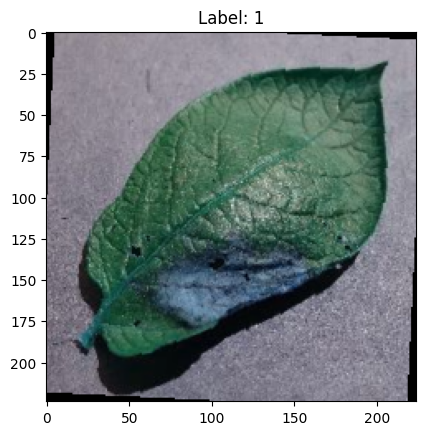

In [7]:
# fetch one batch of data
for images, labels in train_loader:
    # convert the tensor from (C, H, W) to (H, W, C)
    img = images[0].permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # denormalize
    img = np.clip(img, 0, 1)
    
    
    # Display the image
    plt.imshow(img)
    plt.title(f'Label: {labels[0].item()}')
    plt.show()
    break

### Define the Model

In [8]:
#pip install efficientnet_pytorch

In [9]:
# Hyperparameters
learning_rate = 1e-4
num_epochs = 10

In [10]:
# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
num_classes = 3
model_mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all layer 
for param in model_mobilenet.parameters():
    param.requires_grad = False
    
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.classifier[1].in_features, num_classes)

# only the classifier layers will be trainable
for param in model_mobilenet.classifier.parameters():
    param.requires_grad = True

In [18]:
# Move model to the appropriate device
model_mobilenet.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [19]:
# Define optimazer and loss function 
optimizer_mobilenet = optim.Adam(model_mobilenet.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [20]:
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    # Initialize empty lists to sore loss and accuracy values for tran and valid datasets
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    # Loop over the specific number of epochs
    for epoch in range(num_epochs):
        
        running_loss = 0.0
        model.train()      # Set the model on trainig mode
        correct_train = 0
        total_train = 0
        # Iterate over the trainig dataset in batches
        for images, labels in train_loader:
            # Move imgs & labels to the device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass: Compute predicted outputs by passing inputs to the model
            outputs = model(images)  
            loss = criterion(outputs, labels)  # Compute the loss  
            
            # Backward pass and optimization
            optimizer.zero_grad()             # clear the gradient of all optimizer param-rs
            loss.backward()                   # compute gradients
            optimizer.step()                  # update param-rs
            
            # Accumulate the running loss
            running_loss += loss.item() * images.size(0)
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        # Calculate average training loss and accuracy over the epoch
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss) # Store training loss
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval() # set the model to evaluation mode
        val_loss = 0 
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                
                # Forward pass
                outputs = model(images)  
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
        # Calculate average validation loss and accuracy
        val_loss /= len(test_loader.dataset)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss) # Store validation loss
        val_accuracies.append(val_accuracy) # Store accuracy

        # Print Epochs statistics
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, Training Accuracy = {:.2f}, Validation Accuracy: {:.2f}'.format(
            epoch, train_loss, val_loss, train_accuracy, val_accuracy))
        
    return train_losses, val_losses, train_accuracies, val_accuracies # Return the results

# Train the MobileNetV2 Model
***

In [21]:
train_losses_eff, val_losses_eff, train_accuracies_eff, val_accuracies_eff = train(model_mobilenet, train_loader, test_loader, criterion, optimizer_mobilenet, num_epochs)

Epoch: 0, Training Loss: 0.85, Validation Loss: 0.68, Training Accuracy = 0.64, Validation Accuracy: 0.82
Epoch: 1, Training Loss: 0.64, Validation Loss: 0.55, Training Accuracy = 0.80, Validation Accuracy: 0.89
Epoch: 2, Training Loss: 0.53, Validation Loss: 0.46, Training Accuracy = 0.85, Validation Accuracy: 0.89
Epoch: 3, Training Loss: 0.46, Validation Loss: 0.40, Training Accuracy = 0.87, Validation Accuracy: 0.89
Epoch: 4, Training Loss: 0.42, Validation Loss: 0.36, Training Accuracy = 0.87, Validation Accuracy: 0.90
Epoch: 5, Training Loss: 0.37, Validation Loss: 0.33, Training Accuracy = 0.89, Validation Accuracy: 0.91
Epoch: 6, Training Loss: 0.33, Validation Loss: 0.30, Training Accuracy = 0.91, Validation Accuracy: 0.93
Epoch: 7, Training Loss: 0.31, Validation Loss: 0.27, Training Accuracy = 0.92, Validation Accuracy: 0.94
Epoch: 8, Training Loss: 0.29, Validation Loss: 0.25, Training Accuracy = 0.92, Validation Accuracy: 0.95
Epoch: 9, Training Loss: 0.26, Validation Loss

# Plot the training and validation losses
***

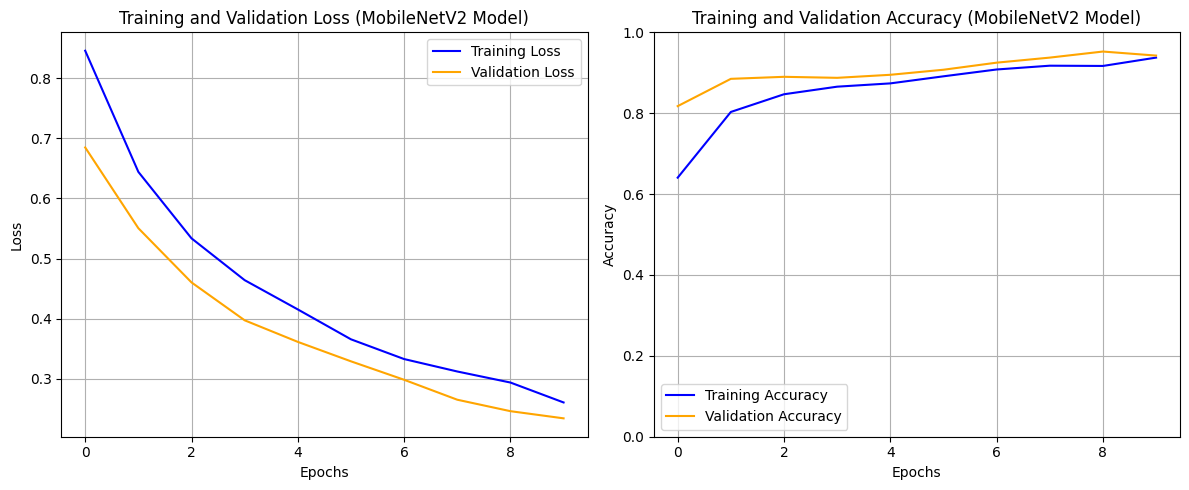

In [22]:
# Set up the figure 
plt.figure(figsize=(12, 5))

# Plotting the training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses_eff, label='Training Loss', color='blue')
plt.plot(val_losses_eff, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss (MobileNetV2 Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plotting the validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_eff, label='Training Accuracy', color='blue')
plt.plot(val_accuracies_eff, label='Validation Accuracy', color='orange')
plt.title("Training and Validation Accuracy (MobileNetV2 Model)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1) # set y-axis limits for accuracy
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
# Save as PNG with 300 dpi
#plt.savefig('training_validation_plots_mobilenet.png', format='png', dpi=300)
plt.show()

# Evaluate the data
***

In [23]:
def evaluate_model(model, data_loader, criterion):
    total_loss = 0
    correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            imageses, labels = images.to(device), labels.to(device)
            
            # Get model outputs
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0) # Accumulate loss

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                
     # Calculate average validation loss and accuracy
    average_loss = total_loss / len(data_loader.dataset)
    accuracy = correct / total
    return average_loss, accuracy           

In [24]:
# Evaluate on train data
train_loss, train_accuracy = evaluate_model(model_mobilenet, train_loader, criterion)
print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.3f}')

Train Loss: 0.2297, Train Accuracy: 0.953


In [25]:
# Evaluate on train data
test_loss, test_accuracy = evaluate_model(model_mobilenet, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.3f}')

Test Loss: 0.2361, Test Accuracy: 0.948


Confusion Matrix (MobileNetV2):
 [[186   8   0]
 [  2 175   0]
 [  0  14  15]]

Classification Report of MobileNetV2 Model:
                        precision    recall  f1-score   support

Potato___Early_blight       0.99      0.96      0.97       194
 Potato___Late_blight       0.89      0.99      0.94       177
     Potato___healthy       1.00      0.52      0.68        29

             accuracy                           0.94       400
            macro avg       0.96      0.82      0.86       400
         weighted avg       0.95      0.94      0.94       400



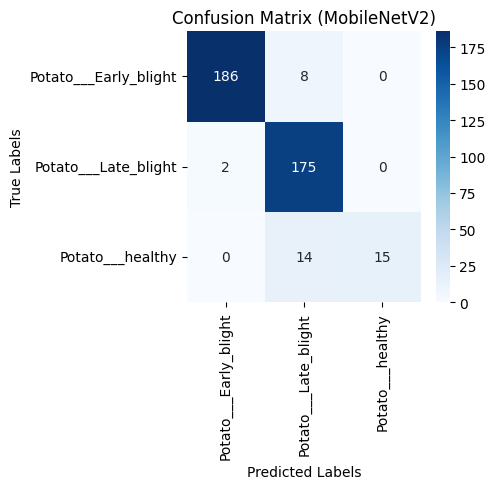

In [29]:
# Generate predictions for the test dataset 
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_mobilenet(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        
# Convert to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate confusion matrix and classification report
confusion = confusion_matrix(y_true, y_pred)
print('Confusion Matrix (MobileNetV2):\n', confusion)

classes_names = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
report = classification_report(y_true, y_pred, target_names=classes_names)
print('\nClassification Report of MobileNetV2 Model:\n', report)

# Visualize the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues',
            xticklabels=classes_names, yticklabels=classes_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (MobileNetV2)')
plt.tight_layout()
# Save as PNG with 300 dpi
plt.savefig('confusion_matrix_mobelinet.png', format='png', dpi=300)
plt.show()